# Linear Model Selection & Regularization

This chapter deals specifically with linear models, but many of the techniques are applicable to non-linear techniques as well. 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from matplotlib import gridspec

from tqdm.notebook import tqdm_notebook

import warnings
warnings.simplefilter('ignore')

plt.style.use('ggplot')

colors= [c['color'] for c in plt.rcParams['axes.prop_cycle']]

## Subset Selection

_Select a subset of predictors (features) can reduce model variability and improve computational costs, while having a negligible effect on predictive power._



### Forward-stepwise Selection

Forward stepwise selection begins with a model containing no predictors, and then adds predictors to the model, one-at-a-time, until all of the predictors are in the model. In particular, at each step the variable that gives the greatest _additional_ improvement to the fit is added to the model.


**Pseudo Code*
```
-let features=[]
-for k in 0,..,p-1:
    * train current model augmented with each of the remaining p-k features
    * choose the feature that gave the biggest increase in model performance
-Select the best model from all trained models
```

In [23]:
credit = pd.read_csv('../data/Credit.csv')

credit.drop(columns=['Gender','Ethnicity'], inplace=True)

credit[['Student','Married']] = credit[['Student','Married']].replace({'Yes': 1, 'No': 0})

credit.head()

,Income,Limit,Rating,Cards,Age,Education,Student,Married,Balance
0,14.891,3606,283,2,34,11,0,1,333
1,106.025,6645,483,3,82,15,1,1,903
2,104.593,7075,514,4,71,11,0,0,580
3,148.924,9504,681,3,36,11,0,0,964
4,55.882,4897,357,2,68,16,0,1,331


In [42]:
from sklearn.linear_model import LinearRegression

def rss(y, yhat):
    return sum((y-yhat)**2)

def stepwise_forward_selection(model, data, label, maximize=True):
    """
    Stepwise forward selection
    """
    X = data.drop(columns=label)
    y = data[label]
    
    features = X.columns.tolist()
    
    selected_features = []
    stepwise_scores = []
    for k in tqdm_notebook(range(len(features))):
        scores = []
        for j in range(len(features)):
            
            X_curr = X[selected_features + [features[j]]]
            
            model.fit(X_curr, y)
            
            preds = model.predict(X_curr)
            scores.append(rss(y, preds))
            
        # select feature with best additional score
        if maximize:
            best_feat, best_score = features[np.argmax(scores)], np.max(scores)
        else:
            best_feat, best_score = features[np.argmin(scores)], np.min(scores)
            
            
        # Remove from pool
        features.remove(best_feat)
        
        selected_features.append(best_feat)
        stepwise_scores.append(best_score)
        
    return selected_features, stepwise_scores

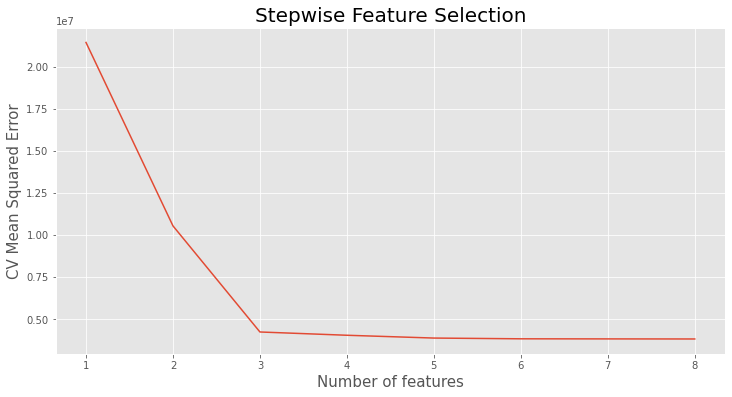

In [43]:
model = LinearRegression()
target = 'Balance'
metric = 'neg_mean_squared_error'
selected_features, stepwise_scores = stepwise_forward_selection(model, credit, target, metric, maximize=False)

plt.figure(figsize=(12,6))
plt.plot(range(1,len(stepwise_scores)+1), stepwise_scores)
plt.title('Stepwise Feature Selection', fontsize=20)
plt.xlabel('Number of features', fontsize=15)
plt.ylabel('CV Mean Squared Error', fontsize=15)
plt.show()

### Selecting the best model

Considering $RSS$ and $R^2$ as evaluation metrics during features is misleading, because $RSS$ will always decrease (and $R^2$ increase) as we add more features to the model. Thus, although we can see that some features are _more important_ than others by considering the above graph, we still cannot make a decision about which combination of features will give the best results on unknown data.


#### Metrics for model selection

For selecting the best model after performing feature selection, there are three variables to consider:


**_Mallows $C_p$:_**
$$
C_p = \frac{1}{n}(RSS + 2d\hat{\sigma}^2)
$$

Where $\hat{\sigma}^2$ is an _estimate_ of the variance of the errors, estimated from the model trained using all the features, and $d$ is the number of features. 


**_Bayesian Information Criteria $BIC$:_**
$$
BIC = \frac{1}{n\hat{\sigma}^2}(RSS + log(n)d\hat{\sigma}^2)
$$

Similarly, $\hat{\sigma}^2$ is an estimate of the variance of the errors on the full model.

Because $BIC$ is now proportional to $log(n)$ rather than $2n$, the $BIC$ statistic generally places a heavier penalty on models with many variables, and hence results in the selection of smaller models than $C_p$.


**Estimating $\hat{\sigma}^2$**

Because $\hat{\sigma}^2$ is estimated on the training set of the full model, we can calculate is using:

$$
\hat{\sigma}^2 = \frac{RSS}{n-d-1}
$$

In [50]:
# Number of samples
n = credit.shape[0]

scores_df = pd.DataFrame(stepwise_scores, columns=['RSS'])

features_nested = []
for f in selected_features:
    features_nested.append(features_nested+[f])
    
    
# Error variance
sigma_est = scores_df['RSS'].min() / (n - scores_df.shape[1] - 1)

scores_df['features'] = features_nested

scores_df['num_features'] = scores_df.index

scores_df['Cp'] = (1/n) * (scores_df['RSS'] + 2*scores_df['num_features'] * sigma_est)

scores_df['BIC'] = (1/(sigma_est*n)) * (scores_df['RSS'] + np.log(n)*scores_df['num_features'] * sigma_est)

scores_df

,RSS,features,num_features,Cp,BIC
0,2.143512e+07,[Rating],0,53587.805082,5.595574
1,1.053254e+07,"[[Rating], Income]",1,26379.237321,2.764467
2,4.227219e+06,"[[Rating], [[Rating], Income], Student]",2,10663.816468,1.133460
3,4.032502e+06,"[[Rating], [[Rating], Income], [[Rating], [['R...",3,10224.906447,1.097608
4,3.866091e+06,"[[Rating], [[Rating], Income], [[Rating], [['R...",4,9856.764398,1.069146
5,3.821620e+06,"[[Rating], [[Rating], Income], [[Rating], [['R...",5,9793.469654,1.072516
6,3.816169e+06,"[[Rating], [[Rating], Income], [[Rating], [['R...",6,9827.727309,1.086071
7,3.811574e+06,"[[Rating], [[Rating], Income], [[Rating], [['R...",7,9864.123749,1.099851


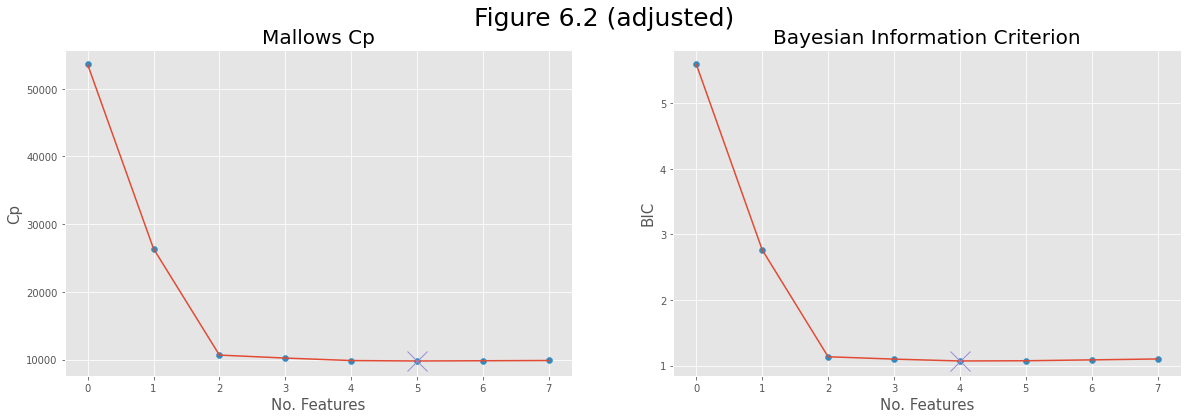

In [73]:
fig, axes = plt.subplots(ncols=2, figsize=(20,6))

ax = axes[0]
metric = 'Cp'
min_idx, min_val = scores_df[metric].idxmin(), scores_df[metric].min()
ax.plot(scores_df['num_features'], scores_df[metric], color=colors[0])
ax.scatter(scores_df['num_features'], scores_df[metric], color=colors[1])
ax.plot(min_idx, min_val, color=colors[2], marker='x', markersize=20)
ax.set_title('Mallows Cp', fontsize=20)
ax.set_xlabel('No. Features', fontsize=15)
ax.set_ylabel(metric, fontsize=15)


ax = axes[1]
metric = 'BIC'
min_idx, min_val = scores_df[metric].idxmin(), scores_df[metric].min()
ax.plot(scores_df['num_features'], scores_df[metric], color=colors[0])
ax.scatter(scores_df['num_features'], scores_df[metric], color=colors[1])
ax.plot(min_idx, min_val, color=colors[2], marker='x', markersize=20)
ax.set_title('Bayesian Information Criterion', fontsize=20)
ax.set_xlabel('No. Features', fontsize=15)
ax.set_ylabel(metric, fontsize=15)


fig.suptitle('Figure 6.2 (adjusted)', fontsize=25);

**Notice** how when using BIC for model selection a model with less features is considered optimal. 

### Model selection using cross validation

In practice, using cross validation for model selection is much more appropriate. We are not constrained to linear models and are making much less assumptions about the data and the models when taking this approach. 

However, actually _selecting_ the best model is not always as easy. If we simply use the model with the lowest mean cross validation score, then using different folds and a different number of folds would give different results. 

One way to overcome this is to use the _one-standard-error rule_, where we select the model with the smallest cross validation score by one standard error (standard deviation in the case of means). When the difference between model performance is less than one standard error, then select the simplest model. 

In [118]:
from sklearn.model_selection import cross_val_score

def stepwise_forward_selection_cv(model, data, label, metric, maximize=True, cv=10):
    """
    Stepwise forward selection using cross-validation
    """
    X = data.drop(columns=label)
    y = data[label]
    
    features = X.columns.tolist()
    
    
    stepwise_results = {
        
    }
    
    stepwise_std = []
    stepwise_scores = []
    selected_features = []
    for k in tqdm_notebook(range(len(features))):
        std = []
        scores = []
        for j in range(len(features)):
            
            X_curr = X[selected_features + [features[j]]]
            
            cv_scores = cross_val_score(model, X_curr, y, scoring=metric, cv=cv)
            
            scores.append(-1*np.mean(cv_scores))
            std.append(np.std(cv_scores))
            
        # select feature with best additional score
        if maximize:
            best_idx = np.argmax(scores)
            
        else:
            best_idx = np.argmin(scores)
        
        best_feat, best_score ,best_std = features[best_idx], scores[best_idx], std[best_idx]
            
        # Remove from pool
        features.remove(best_feat)
        
        selected_features.append(best_feat)
        
        stepwise_results[k] = {
            'features': np.array(selected_features),
            'cv_mean': best_score,
            'cv_std': best_std
        }
        
        
    results_df = pd.DataFrame.from_dict(stepwise_results, orient='index')
    results_df['n_features'] = results_df.index+1
    
    results_df['cv_low'] = results_df['cv_mean'] - results_df['cv_std']
    results_df['cv_high'] = results_df['cv_mean'] + results_df['cv_std']
    
    return results_df

In [119]:
cv_stepwise_results = stepwise_forward_selection_cv(model, credit, target, metric='neg_mean_squared_error', maximize=False)

In [120]:
cv_stepwise_results

,features,cv_mean,cv_std,n_features,cv_low,cv_high
0,[Rating],54251.447982,15372.556508,1,38878.891474,69624.004490
1,"[Rating, Income]",26703.583806,8331.338939,2,18372.244867,35034.922745
2,"[Rating, Income, Student]",10865.870173,3269.576188,3,7596.293985,14135.446361
3,"[Rating, Income, Student, Limit]",10434.030961,2861.060965,4,7572.969996,13295.091926
4,"[Rating, Income, Student, Limit, Cards]",10036.229953,2598.787705,5,7437.442248,12635.017657
5,"[Rating, Income, Student, Limit, Cards, Age]",9936.271848,2607.553475,6,7328.718372,12543.825323
6,"[Rating, Income, Student, Limit, Cards, Age, M...",9968.606350,2624.290612,7,7344.315738,12592.896962
7,"[Rating, Income, Student, Limit, Cards, Age, M...",10021.108586,2706.811281,8,7314.297306,12727.919867


<ErrorbarContainer object of 3 artists>

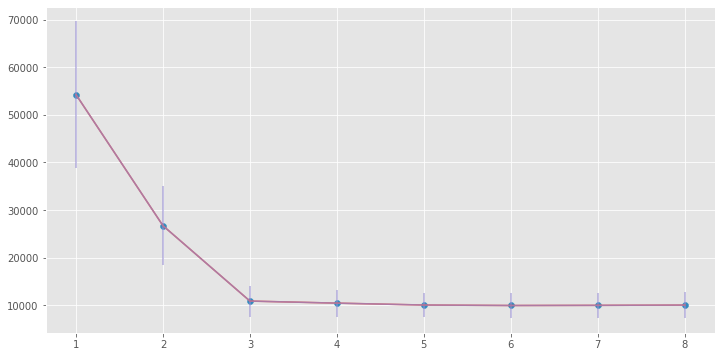

In [127]:
errors = np.c_[cv_stepwise_results['cv_low'], cv_stepwise_results['cv_high']].T

plt.figure(figsize=(12,6))
plt.plot(cv_stepwise_results['n_features'], cv_stepwise_results['cv_mean'], color=colors[0])
plt.scatter(cv_stepwise_results['n_features'], cv_stepwise_results['cv_mean'], color=colors[1])
plt.errorbar(cv_stepwise_results['n_features'], 
             cv_stepwise_results['cv_mean'], 
             yerr=cv_stepwise_results['cv_std'],
             color=colors[2], alpha=0.7)

From this graph, we cannot distinguish between the models (using the one-standard-error rule) with features 3,4..8. Thus we would choose the simplest model with 3 features. 



## Shrinkage Methods